### Derive optimal masks

Derived optimal masks for slp and sst CESM and FOCI for 99.9% / 99% / 95% missing.

**Note:** Have different grid structures. For FOCI, we have 96 x 192 lat-lon grid, with 18,432 total grid points. 0.1% hence means 18 grid points for z500 fields. Whereas, for CESM, we have 96 x 144 lat-lon grid, with 13,824 total grid points. 0.1% hence means 14 grid points.

--> Look for the top 18 grid points from FOCI mean rel. loss reduction maps.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

# # Next block for visualization, only if packages are pre-installed!
# import xarray as xr
# import hvplot.xarray
# import geoviews as gv
# import cartopy
# import cartopy.crs as ccrs
# import cmocean

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data, get_land_silhouette
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

### Load data

#### CESM and FOCI

In [3]:
## Prepare CESM and FOCI samples:

# Set path CESM and FOCI test data:
path_to_ESM_test_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# Load CESM and FOCI test data:
data_CESM = load_data_set(data_path=path_to_ESM_test_data, data_source_name='CESM')
data_FOCI = load_data_set(data_path=path_to_ESM_test_data, data_source_name='FOCI')

# Get z500 anomalies for CESM and FOCI test data:
z500_CESM_anomaly = get_anomalies(feature='geopotential-height', data_set=data_CESM)
z500_FOCI_anomaly = get_anomalies(feature='geopotential-height', data_set=data_FOCI)


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


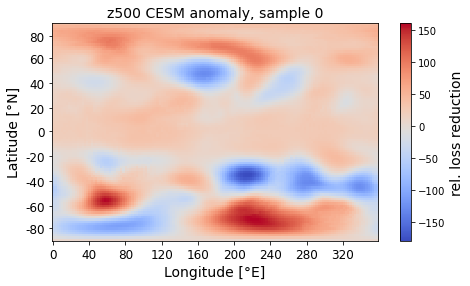

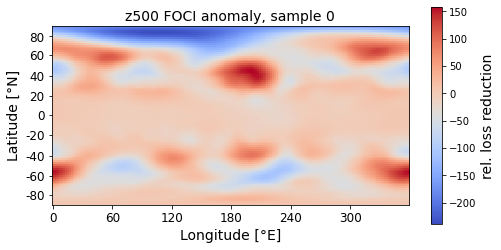

In [5]:
## Plot samples:

# z500 CESM:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(z500_CESM_anomaly[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('z500 CESM anomaly, sample 0', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# z500 FOCI:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(z500_FOCI_anomaly[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('z500 FOCI anomaly, sample 0', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

#### Infer grid dimensions

In [12]:
# Store grid dimensions:
n_lat_slp_CESM = slp_CESM_anomaly.shape[1]
n_lon_slp_CESM = slp_CESM_anomaly.shape[2]
n_lat_slp_FOCI = slp_FOCI_anomaly.shape[1]
n_lon_slp_FOCI = slp_FOCI_anomaly.shape[2]
n_lat_slp_RW= slp_RW_anomaly.shape[1]
n_lon_slp_RW = slp_RW_anomaly.shape[2]
n_lat_sst_CESM = sst_CESM_anomaly.shape[1]
n_lon_sst_CESM = sst_CESM_anomaly.shape[2]
n_lat_sst_FOCI = sst_FOCI_anomaly.shape[1]
n_lon_sst_FOCI = sst_FOCI_anomaly.shape[2]
n_lat_sst_RW= sst_RW_anomaly.shape[1]
n_lon_sst_RW = sst_RW_anomaly.shape[2]

# Check dimensions:
print('CESM')
print('====')
print('slp lat / lon:',n_lat_slp_CESM,'/',n_lon_slp_CESM)
print('sst lat / lon:',n_lat_sst_CESM,'/',n_lon_sst_CESM)

print('\nFOCI')
print('====')
print('slp lat / lon:',n_lat_slp_FOCI,'/',n_lon_slp_FOCI)
print('sst lat / lon:',n_lat_sst_FOCI,'/',n_lon_sst_FOCI)

print('\nRW')
print('==')
print('slp lat / lon:',n_lat_slp_RW,'/',n_lon_slp_RW)
print('sst lat / lon:',n_lat_sst_RW,'/',n_lon_sst_RW)

CESM
====
slp lat / lon: 96 / 144
sst lat / lon: 96 / 144

FOCI
====
slp lat / lon: 96 / 192
sst lat / lon: 96 / 192

RW
==
slp lat / lon: 72 / 144
sst lat / lon: 80 / 176


#### Infer absolute lat / lon values

In [13]:
# Store grid dimensions:
lat_slp_CESM = data_CESM.lat.values
lon_slp_CESM = data_CESM.lon.values
lat_slp_FOCI = data_FOCI.lat.values
lon_slp_FOCI = data_FOCI.lon.values
lat_slp_RW= slp_anomaly_fields_truncate.lat.values
lon_slp_RW = slp_anomaly_fields_truncate.lon.values
lat_sst_CESM = data_CESM.lat.values
lon_sst_CESM = data_CESM.lon.values
lat_sst_FOCI = data_FOCI.lat.values
lon_sst_FOCI = data_FOCI.lon.values
lat_sst_RW= sst_anomaly_fields_truncate.lat.values
lon_sst_RW = sst_anomaly_fields_truncate.lon.values

#### Get masks for valid and invalid grid points in sst RW samples

In [14]:
# Get mask for invalid grid points (= land masses) in RW raw data:
invalid_gridpoints_sst_RW = np.isnan(sst_anomaly_fields_truncate[0].values)
valid_gridpoints_sst_RW = (invalid_gridpoints_sst_RW==False)

### Reload mean rel. loss reduction map for sst FOCI

In [15]:
## Reload parameters and results for experiment:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'FOCI' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'variable'
missing_type = 'range_0_100'
augmentation_factor = 3
run = '_final'
exp_name = '/relevance_1'

# Get path to stored results:
path_to_stored_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_stored_results)

# Reload parameters relevant for data pre-processing for this experiment:
with open(path_to_stored_results / 'parameters.json', 'r') as f:
    parameters=load(f)


train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']
n_samples = parameters['n_samples']
patch_size = parameters['patch_size']
max_patch_num = parameters['max_patch_num']
max_acc_rel_loss_reduction = parameters['max_acc_rel_loss_reduction']

# Print parameters:
print("\nnumber of samples: ", n_samples)
print("patch size: ", patch_size)
print("max. number of patches to include: ", max_patch_num)
print("max. acc. rel. loss as threshold: ", max_acc_rel_loss_reduction)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_0_100_factor_3_final/relevance_1

number of samples:  240
patch size:  1
max. number of patches to include:  50
max. acc. rel. loss as threshold:  0.9


In [16]:
# Reload results for this experiment:
rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# Check dimensions:
print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
print("patch_orders:", patch_orders.shape)
print("rel_loss_reductions:", rel_loss_reductions.shape)
print("abs_loss_reductions:", abs_loss_reductions.shape)
print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (240, 96, 192)
patch_orders: (240, 18432)
rel_loss_reductions: (240, 18432)
abs_loss_reductions: (240, 18432)
acc_rel_loss_reductions: (240, 18432)


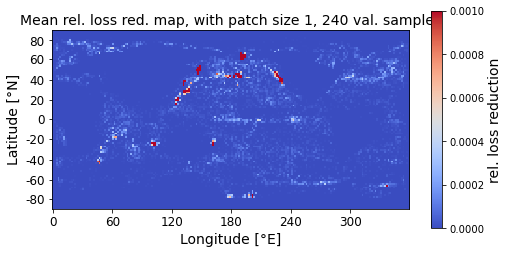

In [28]:
# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.001)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

### Clustering with GMM to find optimal masks

### Optimal masks for sst FOCI grid

- Derive masks for sst FOCI grid: Look for 13 / 129 / 647 clusters (=0.1% / 1% / 5% of VALID grid points for sst FOCI). But as representative for each cluster, don't take the **mean**, but the grid points with **maximum rel. loss reduction**.

#### 99.9% missing

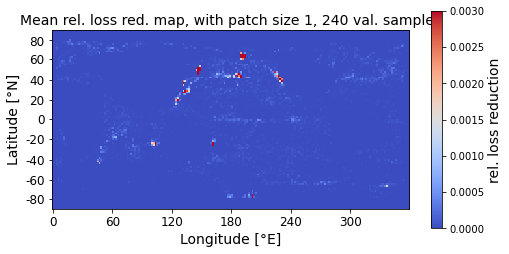

non-zero entries in mean rel. loss reduction map:  5107


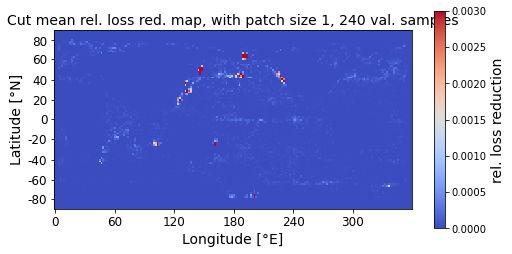

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 5107
number of desired clusters: 13 



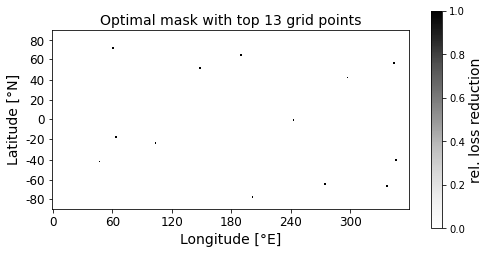

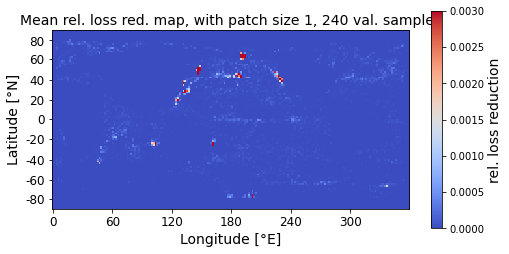

In [29]:
# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 13

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map_cut, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_sst_FOCI):
    
    # Loop over latitude:
    for y in range(n_lat_sst_FOCI):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 13 (=0.1% of valid grid points for FOCI sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_999 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_999_clusters = GMM_999.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over number of clusters:
for i in range(n_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_999_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_999_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_GMM_max = (np.zeros((n_lat_sst_FOCI,n_lon_sst_FOCI))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_999_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_999_GMM_max, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [24]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_999.npy", mask_999_GMM_max)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_0_100_factor_3_final/relevance_1


#### 99% missing

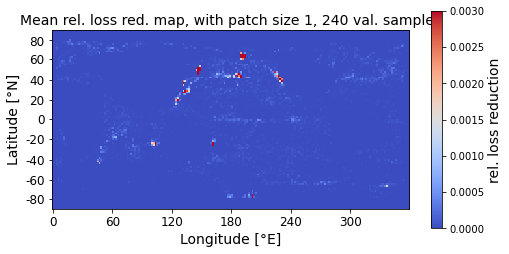

non-zero entries in mean rel. loss reduction map:  5107


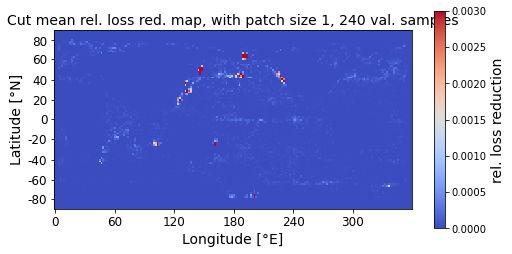

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 5107
number of desired clusters: 129 



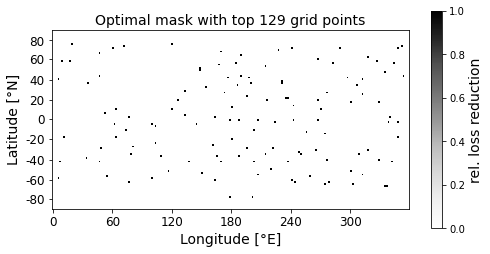

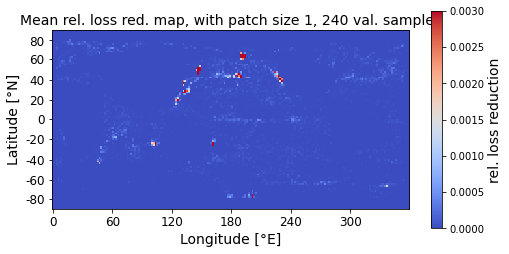

In [30]:
# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 129

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map_cut, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_sst_FOCI):
    
    # Loop over latitude:
    for y in range(n_lat_sst_FOCI):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 129 (=1% of valid grid points for FOCI sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_99 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_99_clusters = GMM_99.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over number of clusters:
for i in range(n_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_99_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_99_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_GMM_max = (np.zeros((n_lat_sst_FOCI,n_lon_sst_FOCI))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_99_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot FLIPPED optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_99_GMM_max, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [27]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_99.npy", mask_99_GMM_max)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_0_100_factor_3_final/relevance_1


#### 95% missing

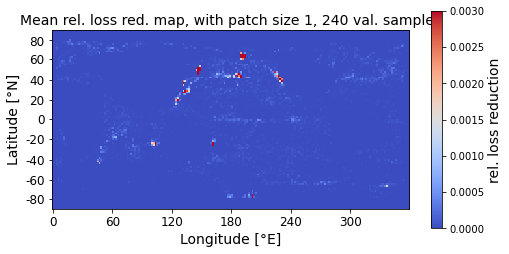

non-zero entries in mean rel. loss reduction map:  5107


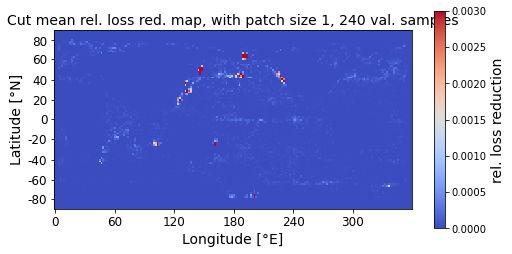

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 5107
number of desired clusters: 647 



/app/conda/lib/python3.8/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


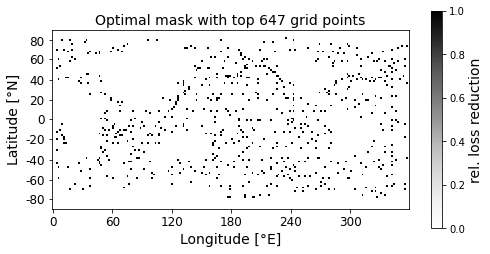

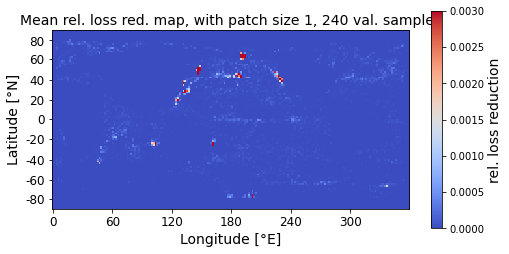

In [33]:
# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 647

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map_cut, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_sst_FOCI):
    
    # Loop over latitude:
    for y in range(n_lat_sst_FOCI):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 647 (=5% of valid grid points for FOCI sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_95 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_95_clusters = GMM_95.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over existing clusters. Note: Can have empty clusters.
for i in np.unique(GMM_95_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_95_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_95_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_GMM_max = (np.zeros((n_lat_sst_FOCI,n_lon_sst_FOCI))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_95_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_95_GMM_max, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [34]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_95.npy", mask_95_GMM_max)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_0_100_factor_3_final/relevance_1


### Transfer optimal mask from sst FOCI to RW grid

 For transfer to sst RW grid: Look for 10 / 99 / 496 cluster means (=0.1% /1% / 5% of VALID grid points for sst RW).
 Again, take as cluster representative the grid points for each cluster with **maximum** rel. loss reduction.

#### 99.9% missing

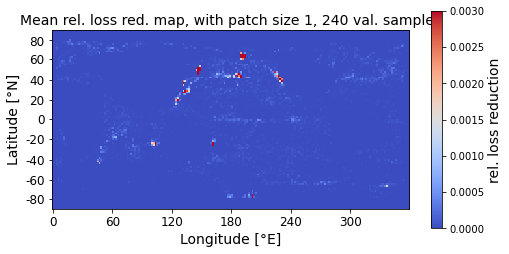

non-zero entries in mean rel. loss reduction map:  5107


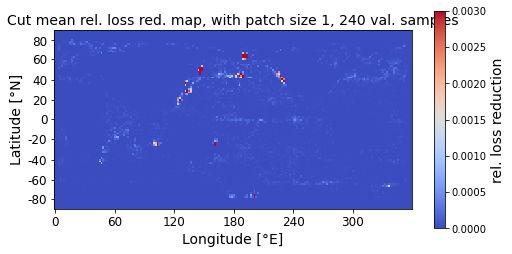

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 5107
number of desired clusters: 10 



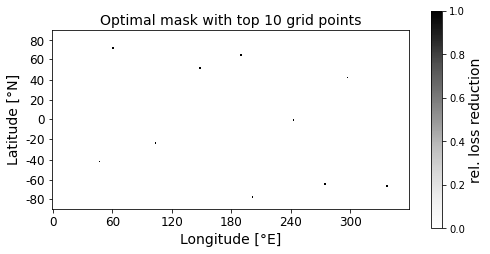

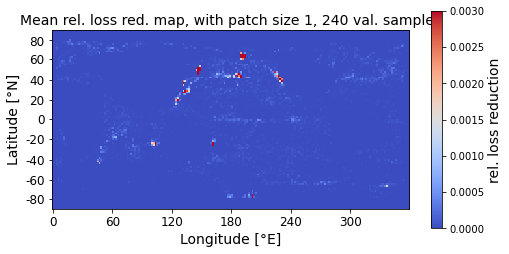

In [36]:
# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 10

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot FLIPPED resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map_cut, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_sst_FOCI):
    
    # Loop over latitude:
    for y in range(n_lat_sst_FOCI):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 10 (=0.1% of valid grid points for RW sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_999 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_999_clusters = GMM_999.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over number of clusters:
for i in range(n_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_999_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_999_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_GMM_max = (np.zeros((n_lat_sst_FOCI,n_lon_sst_FOCI))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_999_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_999_GMM_max, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [37]:
# Create tuples of abs. lon/lat values:
xy_abs = []

# Loop over cluster representatives:
for xy in xy_grid_max:
    
    # Round lat and lon of current cluster center, convert to integer values and get corresponding abs. lat and lon values:
    xy_abs.append([lon_sst_FOCI[np.round(xy[0],0).astype(int)],lat_sst_FOCI[np.round(xy[1],0).astype(int)]])


# # Loop over cluster centers:
# for xy in GMM_999.means_:
    
#     # Round lat and lon of current cluster center, convert to integer values and get corresponding abs. lat and lon values:
#     xy_abs.append([lon_sst_FOCI[np.round(xy[0],0).astype(int)],lat_sst_FOCI[np.round(xy[1],0).astype(int)]])
    
# Convert list of xy-tuples to np.array:
xy_abs = np.array(xy_abs)

In [38]:
## Transfer absolute lat and lon values to closest possible RW values:

# Initialize storage for transfered absolute lon/lat tuples, as grid position and abs. values:
xy_grid_RW = []
xy_abs_RW = []

# Loop over lon/lat tuples containing absolute lon/lat values for FOCI grid:
for xy in xy_abs:
    
    # Get position of closest possible lon and lat values from RW grid for current tuple:
    lon_RW_grid = np.abs(lon_sst_RW - xy[0]).argmin()
    lat_RW_grid = np.abs(lat_sst_RW - xy[1]).argmin()
    
    # Get corresponding abs. lon and lat values:
    lon_RW_abs = lon_sst_RW[lon_RW_grid]
    lat_RW_abs = lat_sst_RW[lat_RW_grid]
    
    # Store grid positions and abs. lon and lat values for RW grid for current tuple:
    xy_grid_RW.append([lon_RW_grid,lat_RW_grid])
    xy_abs_RW.append([lon_RW_abs,lat_RW_abs])
    
# Convert lists of xy-tuples to np.arrays:
xy_grid_RW = np.array(xy_grid_RW)
xy_abs_RW = np.array(xy_abs_RW)

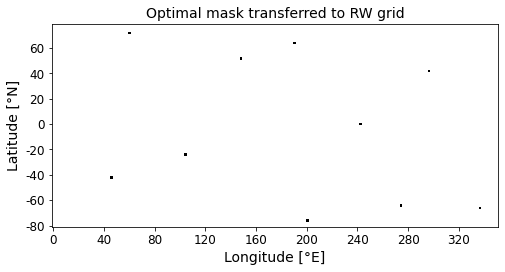

In [49]:
## Create optimal mask from transfered grid positions:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_RW = (np.zeros((n_lat_sst_RW,n_lon_sst_RW))!=0)

# Loop over cluster means:
for xy in xy_grid_RW:
    # Set grid points to True. 
    mask_999_RW[xy[1],xy[0]]=True
    
# Manually shift single grid points, that otherwise is placed over land in RW grid.
mask_999_RW[78,100]=False
mask_999_RW[77,100]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_999_RW, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask transferred to RW grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [50]:
## Ultimately check, if any transfered grid point is placed over land in RW grid:

# Copy mask:
temp_mask = np.copy(mask_999_RW)

# Set land masses to zero:
temp_mask[invalid_gridpoints_sst_RW] = 0

# Again check for number of grid points:
print('Wanted',n_clusters,'grid points in optimal mask transfered to RW.')
print('Have',np.sum(mask_999_RW),'grid points from clustering.')
print('Of these,',np.sum(temp_mask),'are valid grid points on RW grid.')

Wanted 10 grid points in optimal mask transfered to RW.
Have 10 grid points from clustering.
Of these, 10 are valid grid points on RW grid.


In [51]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
np.save(path_to_store_masks / "optimal_sampling_mask_999_realworld.npy", mask_999_RW)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_0_100_factor_3_final/relevance_1


#### 99% missing

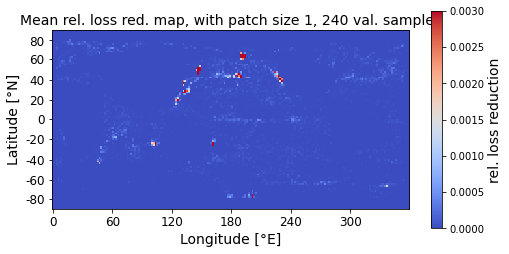

non-zero entries in mean rel. loss reduction map:  5107


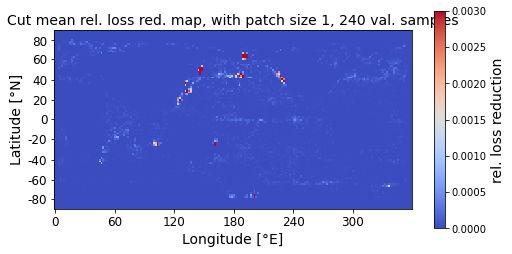

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 5107
number of desired clusters: 99 



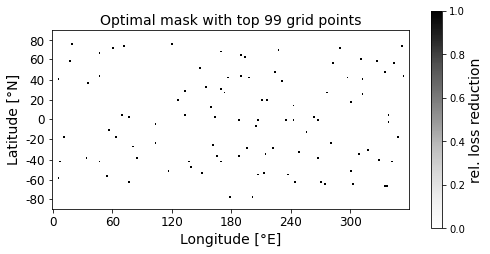

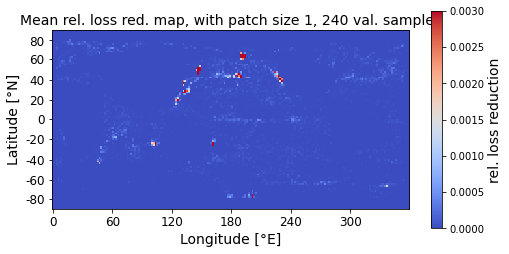

In [80]:
# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 99

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map_cut, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_sst_FOCI):
    
    # Loop over latitude:
    for y in range(n_lat_sst_FOCI):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 99 (=1% of valid grid points for RW sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_99 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_99_clusters = GMM_99.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over existing clusters. Note: Can have empty clusters.
for i in np.unique(GMM_99_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_99_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_99_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_GMM_max = (np.zeros((n_lat_sst_FOCI,n_lon_sst_FOCI))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_99_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_99_GMM_max, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

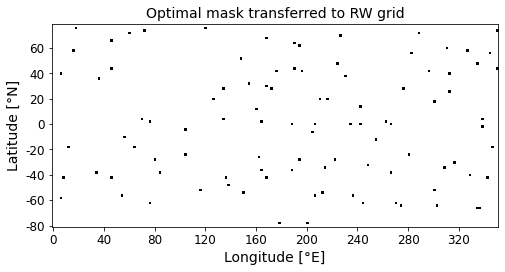

Wanted 99 grid points in optimal mask transfered to RW.
Have 99 grid points from clustering.
Of these, 92 are valid grid points on RW grid.


In [81]:
# Create tuples of abs. lon/lat values:
xy_abs = []

# Loop over cluster representatives:
for xy in xy_grid_max:
    
    # Round lat and lon of current cluster center, convert to integer values and get corresponding abs. lat and lon values:
    xy_abs.append([lon_sst_FOCI[np.round(xy[0],0).astype(int)],lat_sst_FOCI[np.round(xy[1],0).astype(int)]])

# Convert list of xy-tuples to np.array:
xy_abs = np.array(xy_abs)

## Transfer absolute lat and lon values to closest possible RW values:

# Initialize storage for transfered absolute lon/lat tuples, as grid position and abs. values:
xy_grid_RW = []
xy_abs_RW = []

# Loop over lon/lat tuples containing absolute lon/lat values for FOCI grid:
for xy in xy_abs:
    
    # Get position of closest possible lon and lat values from RW grid for current tuple:
    lon_RW_grid = np.abs(lon_sst_RW - xy[0]).argmin()
    lat_RW_grid = np.abs(lat_sst_RW - xy[1]).argmin()
    
    # Get corresponding abs. lon and lat values:
    lon_RW_abs = lon_sst_RW[lon_RW_grid]
    lat_RW_abs = lat_sst_RW[lat_RW_grid]
    
    # Store grid positions and abs. lon and lat values for RW grid for current tuple:
    xy_grid_RW.append([lon_RW_grid,lat_RW_grid])
    xy_abs_RW.append([lon_RW_abs,lat_RW_abs])
    
# Convert lists of xy-tuples to np.arrays:
xy_grid_RW = np.array(xy_grid_RW)
xy_abs_RW = np.array(xy_abs_RW)

## Create optimal mask from transfered grid positions:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_RW = (np.zeros((n_lat_sst_RW,n_lon_sst_RW))!=0)

# Loop over cluster means:
for xy in xy_grid_RW:
    # Set grid points to True. 
    mask_99_RW[xy[1],xy[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_99_RW, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask transferred to RW grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

## Ultimately check, if any transfered grid point is placed over land in RW grid:

# Copy mask:
temp_mask = np.copy(mask_99_RW)

# Set land masses to zero:
temp_mask[invalid_gridpoints_sst_RW] = 0

# Again check for number of grid points:
print('Wanted',n_clusters,'grid points in optimal mask transfered to RW.')
print('Have',np.sum(mask_99_RW),'grid points from clustering.')
print('Of these,',np.sum(temp_mask),'are valid grid points on RW grid.')

In [69]:
# # Loop over cluster means:
# for xy in xy_grid_RW:
    
#     # Look in detail for grid points, that are placed over land in RW grid and their direct neighbors:
#     if invalid_gridpoints_sst_RW[xy[1],xy[0]] == True:
#         print(xy)
#         print(invalid_gridpoints_sst_RW[xy[1]-1:xy[1]+2,xy[0]-1:xy[0]+2],'\n')

In [83]:
# Loop over cluster means:
for xy in xy_grid_RW:
    
    # Look in detail for grid points, that are placed over land in RW grid and their direct neighbors:
    if invalid_gridpoints_sst_RW[xy[1],xy[0]] == True:
        
        # Check direct neighbors for valid grid points:
        for x in range(-1,2):
            for y in range(-1,2):
                
                # Check, if we found a valid grid point:
                if invalid_gridpoints_sst_RW[xy[1]+x,xy[0]+y] == False:
                    
                    # Shift grid point in optimal mask:
                    mask_99_RW[xy[1],xy[0]]=False
                    mask_99_RW[xy[1]+x,xy[0]+y]=True
                break

In [71]:
## Repeat ultimately check, if any transfered grid point is placed over land in RW grid:

# Copy mask:
temp_mask = np.copy(mask_99_RW)

# Set land masses to zero:
temp_mask[invalid_gridpoints_sst_RW] = 0

# Again check for number of grid points:
print('Wanted',n_clusters,'grid points in optimal mask transfered to RW.')
print('Have',np.sum(mask_99_RW),'grid points from clustering.')
print('Of these,',np.sum(temp_mask),'are valid grid points on RW grid.')

Wanted 99 grid points in optimal mask transfered to RW.
Have 100 grid points from clustering.
Of these, 99 are valid grid points on RW grid.


In [72]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_99_realworld.npy", mask_99_RW)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_0_100_factor_3_final/relevance_1


#### 95% missing

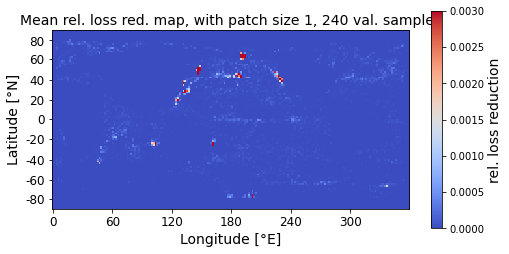

non-zero entries in mean rel. loss reduction map:  5107


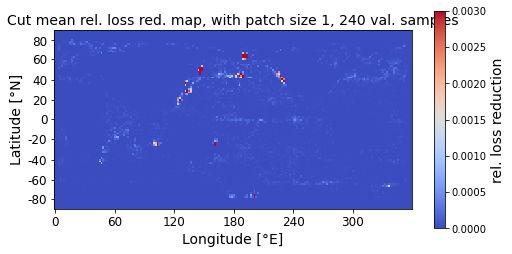

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 5107
number of desired clusters: 496 



/app/conda/lib/python3.8/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


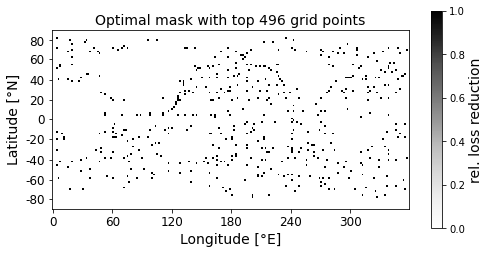

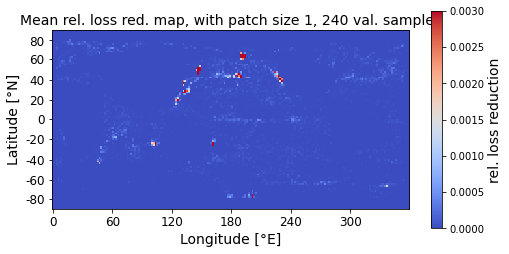

In [73]:
# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 496

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map_cut, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_sst_FOCI):
    
    # Loop over latitude:
    for y in range(n_lat_sst_FOCI):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 496 (=5% of valid grid points for RW sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_95 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_95_clusters = GMM_95.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over existing clusters. Note: Can have empty clusters.
for i in np.unique(GMM_95_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_95_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_95_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_GMM_max = (np.zeros((n_lat_sst_FOCI,n_lon_sst_FOCI))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_95_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_95_GMM_max, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

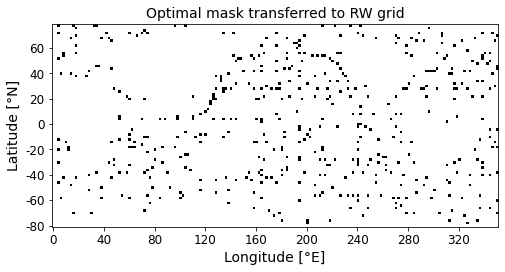

Wanted 496 grid points in optimal mask transfered to RW.
Have 490 grid points from clustering.
Of these, 462 are valid grid points on RW grid.


In [76]:
# Create tuples of abs. lon/lat values:
xy_abs = []

# Loop over cluster representatives:
for xy in xy_grid_max:
    
    # Round lat and lon of current cluster center, convert to integer values and get corresponding abs. lat and lon values:
    xy_abs.append([lon_sst_FOCI[np.round(xy[0],0).astype(int)],lat_sst_FOCI[np.round(xy[1],0).astype(int)]])
    
# Convert list of xy-tuples to np.array:
xy_abs = np.array(xy_abs)

## Transfer absolute lat and lon values to closest possible RW values:

# Initialize storage for transfered absolute lon/lat tuples, as grid position and abs. values:
xy_grid_RW = []
xy_abs_RW = []

# Loop over lon/lat tuples containing absolute lon/lat values for FOCI grid:
for xy in xy_abs:
    
    # Get position of closest possible lon and lat values from RW grid for current tuple:
    lon_RW_grid = np.abs(lon_sst_RW - xy[0]).argmin()
    lat_RW_grid = np.abs(lat_sst_RW - xy[1]).argmin()
    
    # Get corresponding abs. lon and lat values:
    lon_RW_abs = lon_sst_RW[lon_RW_grid]
    lat_RW_abs = lat_sst_RW[lat_RW_grid]
    
    # Store grid positions and abs. lon and lat values for RW grid for current tuple:
    xy_grid_RW.append([lon_RW_grid,lat_RW_grid])
    xy_abs_RW.append([lon_RW_abs,lat_RW_abs])
    
# Convert lists of xy-tuples to np.arrays:
xy_grid_RW = np.array(xy_grid_RW)
xy_abs_RW = np.array(xy_abs_RW)

## Create optimal mask from transfered grid positions:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_RW = (np.zeros((n_lat_sst_RW,n_lon_sst_RW))!=0)

# Loop over cluster means:
for xy in xy_grid_RW:
    # Set grid points to True. 
    mask_95_RW[xy[1],xy[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_95_RW, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask transferred to RW grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

## Ultimately check, if any transfered grid point is placed over land in RW grid:

# Copy mask:
temp_mask = np.copy(mask_95_RW)

# Set land masses to zero:
temp_mask[invalid_gridpoints_sst_RW] = 0

# Again check for number of grid points:
print('Wanted',n_clusters,'grid points in optimal mask transfered to RW.')
print('Have',np.sum(mask_95_RW),'grid points from clustering.')
print('Of these,',np.sum(temp_mask),'are valid grid points on RW grid.')


In [77]:
# Loop over cluster means:
for xy in xy_grid_RW:
    
    # Look in detail for grid points, that are placed over land in RW grid and their direct neighbors:
    if invalid_gridpoints_sst_RW[xy[1],xy[0]] == True:
        
        # Check direct neighbors for valid grid points:
        for x in range(-1,2):
            for y in range(-1,2):
                
                # Check, if we found a valid grid point:
                if invalid_gridpoints_sst_RW[xy[1]+x,xy[0]+y] == False:
                    
                    # Shift grid point in optimal mask:
                    mask_95_RW[xy[1],xy[0]]=False
                    mask_95_RW[xy[1]+x,xy[0]+y]=True
                break

In [78]:
## Ultimately check, if any transfered grid point is placed over land in RW grid:

# Copy mask:
temp_mask = np.copy(mask_95_RW)

# Set land masses to zero:
temp_mask[invalid_gridpoints_sst_RW] = 0

# Again check for number of grid points:
print('Wanted',n_clusters,'grid points in optimal mask transfered to RW.')
print('Have',np.sum(mask_95_RW),'grid points from clustering.')
print('Of these,',np.sum(temp_mask),'are valid grid points on RW grid.')


Wanted 496 grid points in optimal mask transfered to RW.
Have 503 grid points from clustering.
Of these, 496 are valid grid points on RW grid.


In [79]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_95_realworld.npy", mask_95_RW)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_0_100_factor_3_final/relevance_1
